In [1]:
import tensorflow as tf
import numpy as np

In [42]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

In [3]:
def pad_and_concat(sequences):  # sequences shape: [batch_size, len, dims...] -> ([batch_size, maxlen, dims...], [len])
    arrays = [np.asarray(seq) for seq in sequences]
    lengths = np.asarray([array.shape[0] for array in arrays], dtype=np.int32)
    maxlen = np.max(lengths)
    arrays = [np.pad(array, [(0, maxlen - array.shape[0]), (0, 0)], 'constant', constant_values=0) for array in arrays]
    return np.asarray(arrays), lengths
    

In [4]:
small_cnf, small_lengths = pad_and_concat(
    [
        [[1, -2], [2, 1]],
        [[-2, -1], [1, -2]],
        [[-1, -1], [-2, -2], [-1, -2]],
        [[1, -2], [2, 1]],
        [[-2, -1], [1, -2]],
        [[-1, -1], [-2, -2], [-1, -2]],
     ])
small_sol = np.asarray([
    [1, 0, 1, 1, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0],
    [1, 0, 1, 1, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0],
])

In [5]:
print(small_cnf)
print(small_lengths)

[[[ 1 -2]
  [ 2  1]
  [ 0  0]]

 [[-2 -1]
  [ 1 -2]
  [ 0  0]]

 [[-1 -1]
  [-2 -2]
  [-1 -2]]

 [[ 1 -2]
  [ 2  1]
  [ 0  0]]

 [[-2 -1]
  [ 1 -2]
  [ 0  0]]

 [[-1 -1]
  [-2 -2]
  [-1 -2]]]
[2 2 3 2 2 3]


In [6]:
VARIABLE_NUM = 3
EMBEDDING_SIZE = 8
CLAUSE_SIZE = 2
LSTM_STATE_SIZE = 8
batch_size = 6

In [7]:
def assert_shape(matrix, shape: list):
    act_shape = matrix.get_shape().as_list()
    assert act_shape == shape, "got shape {}, expected {}".format(act_shape, shape)

In [8]:
class Graph:
    def __init__(self):
        self.inputs = tf.placeholder(tf.int32, shape=(batch_size, None, CLAUSE_SIZE), name='inputs')
        self.lengths = tf.placeholder(tf.int32, shape=(batch_size,), name='lengths')
        self.labels = tf.placeholder(tf.float32, shape=(batch_size, VARIABLE_NUM*2), name='labels')
        
        vars_ = tf.abs(self.inputs)
        signs = tf.cast(tf.sign(self.inputs), tf.float32)  # shape: [batch_size, None, CLAUSE_SIZE]

        embeddings = tf.Variable(tf.random_uniform([VARIABLE_NUM + 1, EMBEDDING_SIZE], -1., 1), name='embeddings')

        var_embeddings = tf.nn.embedding_lookup(embeddings, vars_)
        # var_embeddings shape: [None, None, CLAUSE_SIZE, EMBEDDING_SIZE]
        
        clause_preembeddings = tf.concat(
            [tf.reshape(var_embeddings, [batch_size, -1, CLAUSE_SIZE * EMBEDDING_SIZE]), 
             signs],
            axis=2)
        
        PREEMBEDDING_SIZE = EMBEDDING_SIZE * CLAUSE_SIZE + CLAUSE_SIZE
        assert_shape(clause_preembeddings, 
                     [batch_size, None, PREEMBEDDING_SIZE])
        
        clause_w = tf.Variable(tf.random_normal(
            [PREEMBEDDING_SIZE, EMBEDDING_SIZE]), name='clause_w')
        clause_b = tf.Variable(tf.random_normal([EMBEDDING_SIZE]), name='clause_b')
        clause_embeddings = tf.reshape(tf.sigmoid(
            tf.reshape(clause_preembeddings, [-1, PREEMBEDDING_SIZE]) @ clause_w + clause_b), 
                                       [batch_size, -1, EMBEDDING_SIZE])
        # shape: [None, None, EMBEDDING_SIZE]
        
        lstm = tf.contrib.rnn.BasicLSTMCell(LSTM_STATE_SIZE)
        hidden_state = tf.zeros([batch_size, LSTM_STATE_SIZE])
        current_state = tf.zeros([batch_size, LSTM_STATE_SIZE])
        state = hidden_state, current_state
        
        _, lstm_final_state = tf.nn.dynamic_rnn(lstm, clause_embeddings, dtype=tf.float32, 
                                               sequence_length=self.lengths
                                               )
        formula_embedding = lstm_final_state.h
            
        assert_shape(formula_embedding, [batch_size, LSTM_STATE_SIZE])
            
        softmax_w = tf.Variable(tf.random_normal([LSTM_STATE_SIZE, VARIABLE_NUM*2]), name='softmax_w')
        softmax_b = tf.Variable(tf.random_normal([VARIABLE_NUM*2]), name='softmax_b')
        
        self.logits = formula_embedding @ softmax_w + softmax_b
        self.loss = tf.losses.sigmoid_cross_entropy(self.labels, self.logits) 
        self.probabilities = tf.sigmoid(self.logits)

tf.reset_default_graph()
model = Graph()

In [9]:
np.set_printoptions(precision=2, suppress=True)

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    probs = sess.run([model.probabilities], feed_dict={
        model.inputs: small_cnf,
        model.lengths: small_lengths
    })
    
print(probs)

[array([[0.11, 0.36, 0.13, 0.55, 0.44, 0.32],
       [0.1 , 0.37, 0.1 , 0.56, 0.5 , 0.29],
       [0.06, 0.39, 0.1 , 0.62, 0.51, 0.35],
       [0.11, 0.36, 0.13, 0.55, 0.44, 0.32],
       [0.1 , 0.37, 0.1 , 0.56, 0.5 , 0.29],
       [0.06, 0.39, 0.1 , 0.62, 0.51, 0.35]], dtype=float32)]


In [11]:
with tf.Session() as sess:
    train_op = tf.train.AdamOptimizer(learning_rate=0.1).minimize(model.loss)
    sess.run(tf.global_variables_initializer())
    for _ in range(100):
        sess.run(train_op, feed_dict={
            model.inputs: small_cnf,
            model.labels: small_sol,
            model.lengths: small_lengths
        })
    probs = sess.run(model.probabilities, feed_dict={
        model.inputs: small_cnf,
        model.lengths: small_lengths
    })
    
probs

array([[1., 0., 1., 1., 0., 0.],
       [1., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [1., 0., 1., 1., 0., 0.],
       [1., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.]], dtype=float32)

In [12]:
from cnf import get_random_kcnfs

In [13]:
def sat_array():
    for k in range(1, 6):
        for var_num in range(2, 5):
            for clause_num in range(3, 10):
                sat = {True: 0, False: 0}
                for _ in range(100):
                    sat[cnf.get_random_kcnf(k, var_num, clause_num).satisfiable()] += 1
                print(k, var_num, clause_num, sat)
# sat_array()

In [14]:
NUM_VARS = 3

In [15]:
cnfs = get_random_kcnfs(3000, CLAUSE_SIZE, VARIABLE_NUM, 10)
cnfs = [cnf for cnf in cnfs if cnf.satisfiable()]
print("#samples:", len(cnfs))

#samples: 2253


In [16]:
#labels = [cnf.satisfiable() for cnf in cnfs]
labels = []
for cnf in cnfs:
    correct_steps = cnf.get_correct_steps()
    label = []
    # for every variable, for true, then for false
    for v in range(1, NUM_VARS+1):
        for sv in [v, -v]:
            result = 1.0 if sv in correct_steps else 0.0
            label.append(result)
    labels.append(label)
assert all(len(label) == 2*NUM_VARS for label in labels)
print("labels generated")

labels generated


In [21]:
cnfs_train, cnfs_test, labels_train, labels_test = train_test_split(cnfs, labels)

In [18]:
def chunks(lists, chunk_size):
    return [[it[i:i + chunk_size] for it in lists] for i in range(0, len(lists[0]), chunk_size)]

In [19]:
chunks([list(range(10)), list(range(10, 20))], 2)

[[[0, 1], [10, 11]],
 [[2, 3], [12, 13]],
 [[4, 5], [14, 15]],
 [[6, 7], [16, 17]],
 [[8, 9], [18, 19]]]

Epoch 0
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90


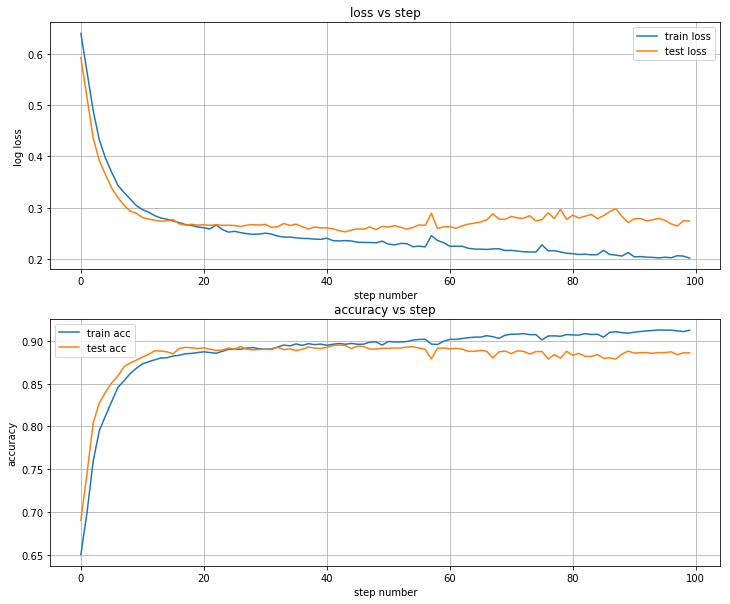

In [41]:
glob_losses = []
glob_accs = []
glob_test_losses = []
glob_test_accs = []

with tf.Session() as sess:
    train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(model.loss)
    sess.run(tf.global_variables_initializer())
    
    EPOCHS = 100
    PRINTS = 10
    for epoch_num in range(EPOCHS):
        if epoch_num % (EPOCHS/PRINTS) == 0 or epoch_num == 1:
            print("Epoch", epoch_num)
        losses = []
        accs = []
        test_losses = []
        test_accs = []
        for (batch_cnfs, batch_labels) in chunks((cnfs_train, labels_train), batch_size):
            if len(batch_cnfs) < batch_size:
                continue
            inputs, lengths = pad_and_concat([cnf.clauses for cnf in batch_cnfs])
            #_, loss, probs = sess.run([train_op, model.loss, model.probabilities], feed_dict={
            _, loss, probs = sess.run([train_op, model.loss, model.probabilities], feed_dict={
                model.inputs: inputs,
                model.labels: batch_labels,
                model.lengths: lengths
            })
            losses.append(loss)
            accs.append(1 - np.mean(np.abs(np.around(probs) - np.asarray(batch_labels))))
        
        for (batch_cnfs, batch_labels) in chunks((cnfs_test, labels_test), batch_size):
            if len(batch_cnfs) < batch_size:
                continue
            inputs, lengths = pad_and_concat([cnf.clauses for cnf in batch_cnfs])
            loss, probs = sess.run([model.loss, model.probabilities], feed_dict={
                model.inputs: inputs,
                model.labels: batch_labels,
                model.lengths: lengths
            })
            test_losses.append(loss)
            test_accs.append(1 - np.mean(np.abs(np.around(probs) - np.asarray(batch_labels))))
            
        glob_losses.append(np.mean(np.asarray(losses)))
        glob_accs.append(np.mean(accs))
        glob_test_losses.append(np.mean(np.asarray(test_losses)))
        glob_test_accs.append(np.mean(test_accs))

    plt.figure(figsize=(12.0, 10.0))

    plt.subplot(2, 1, 1)
    plt.grid(True)
    plt.title("loss vs step")
    plt.ylabel("log loss")
    plt.xlabel("step number")
    plt.plot(glob_losses, label="train loss")
    plt.plot(glob_test_losses, label="test loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.grid(True)
    plt.title("accuracy vs step")
    plt.ylabel("accuracy")
    plt.xlabel("step number")
    plt.plot(glob_accs, label="train acc")
    plt.plot(glob_test_accs, label="test acc")
    plt.legend()

    plt.show()


Epoch 0
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90


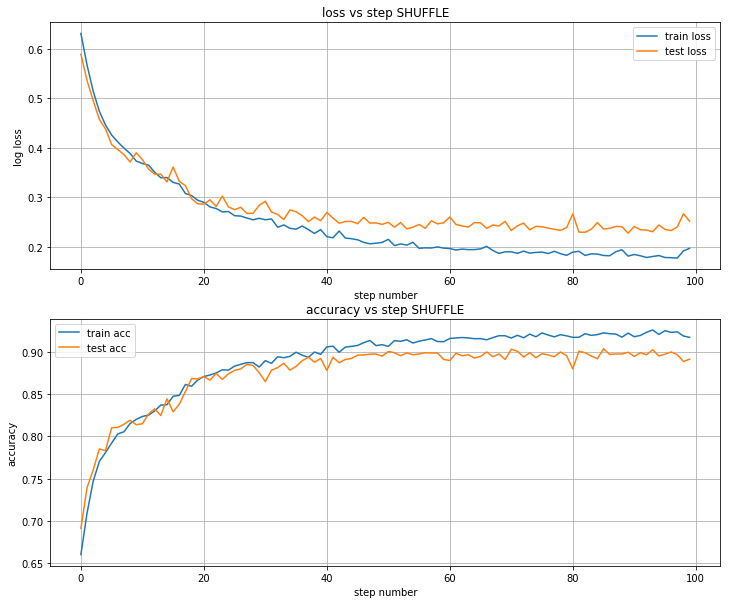

In [44]:
glob_losses = []
glob_accs = []
glob_test_losses = []
glob_test_accs = []

with tf.Session() as sess:
    train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(model.loss)
    sess.run(tf.global_variables_initializer())
    
    EPOCHS = 100
    PRINTS = 10
    for epoch_num in range(EPOCHS):
        if epoch_num % (EPOCHS/PRINTS) == 0 or epoch_num == 1:
            print("Epoch", epoch_num)
        losses = []
        accs = []
        test_losses = []
        test_accs = []
        cnfs_train, labels_train = shuffle(cnfs_train, labels_train)
        for (batch_cnfs, batch_labels) in chunks((cnfs_train, labels_train), batch_size):
            if len(batch_cnfs) < batch_size:
                continue
            inputs, lengths = pad_and_concat([cnf.clauses for cnf in batch_cnfs])
            #_, loss, probs = sess.run([train_op, model.loss, model.probabilities], feed_dict={
            _, loss, probs = sess.run([train_op, model.loss, model.probabilities], feed_dict={
                model.inputs: inputs,
                model.labels: batch_labels,
                model.lengths: lengths
            })
            losses.append(loss)
            accs.append(1 - np.mean(np.abs(np.around(probs) - np.asarray(batch_labels))))
        
        for (batch_cnfs, batch_labels) in chunks((cnfs_test, labels_test), batch_size):
            if len(batch_cnfs) < batch_size:
                continue
            inputs, lengths = pad_and_concat([cnf.clauses for cnf in batch_cnfs])
            loss, probs = sess.run([model.loss, model.probabilities], feed_dict={
                model.inputs: inputs,
                model.labels: batch_labels,
                model.lengths: lengths
            })
            test_losses.append(loss)
            test_accs.append(1 - np.mean(np.abs(np.around(probs) - np.asarray(batch_labels))))
            
        glob_losses.append(np.mean(np.asarray(losses)))
        glob_accs.append(np.mean(accs))
        glob_test_losses.append(np.mean(np.asarray(test_losses)))
        glob_test_accs.append(np.mean(test_accs))

    plt.figure(figsize=(12.0, 10.0))

    plt.subplot(2, 1, 1)
    plt.grid(True)
    plt.title("loss vs step SHUFFLE")
    plt.ylabel("log loss")
    plt.xlabel("step number")
    plt.plot(glob_losses, label="train loss")
    plt.plot(glob_test_losses, label="test loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.grid(True)
    plt.title("accuracy vs step SHUFFLE")
    plt.ylabel("accuracy")
    plt.xlabel("step number")
    plt.plot(glob_accs, label="train acc")
    plt.plot(glob_test_accs, label="test acc")
    plt.legend()

    plt.show()
